# CONTENT BASED IMAGE RETRIEVAL:

 It is the problem of searching the related Images of the query Image in the large database.
This task gives us a flavor of the reverse image search, where we can use certain images to find related images.


# Download The Data

In [ ]:
!pip install mxnet
!pip install gluoncv

     |████████████████████████████████| 47.3 MB 1.9 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 1.3 MB 4.6 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from gluoncv import model_zoo,data, utils
from matplotlib import pyplot as plt
from gluoncv.data import VOCDetection
import pickle
import numpy as np
import os
from matplotlib import pyplot as plt
from gluoncv.utils import viz

/usr/local/lib/python3.7/dist-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.9.0` and `torch==1.10.0+cu111` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


In [ ]:
def download_voc(path, overwrite=False):
    _DOWNLOAD_URLS = [
                      ('http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar',
         '34ed68851bce2a36e2a223fa52c661d592c66b3c'),
        ('http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar',
         '41a8d6e12baa5ab18ee7f8f8029b9e11805b4ef1'),
        ('http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar',
         '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')]
    makedirs(path)
    for url, checksum in _DOWNLOAD_URLS:
        filename = download(url, path=path, overwrite=overwrite, sha1_hash=checksum)
        # extract
        with tarfile.open(filename) as tar:
            tar.extractall(path=path)

In [ ]:
path ="/content/drive/MyDrive"
if not (os.path.exists(os.path.join(path, 'VOC2007')) or os.path.exists(os.path.join(path, 'VOC2012'))):
        #Datset Not available, download it
        os.mkdir(path)
        download_voc(path)
        shutil.move(os.path.join(path, 'VOCdevkit', 'VOC2007'), os.path.join(path, 'VOC2007'))
        shutil.move(os.path.join(path, 'VOCdevkit', 'VOC2012'), os.path.join(path, 'VOC2012'))
        shutil.rmtree(os.path.join(path, 'VOCdevkit'))
else:
  print("Dataset Found in Your Google Drive")


Dataset Found in Your Google Drive


In [ ]:
net = model_zoo.get_model('ssd_512_resnet50_v1_voc', pretrained=True)

/usr/local/lib/python3.7/dist-packages/mxnet/gluon/block.py:1784: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


100%|██████████| 132723/132723 [00:04<00:00, 27785.26KB/s]


In [ ]:
im_fname = utils.download('https://github.com/dmlc/web-data/blob/master/' +
                          'gluoncv/detection/street_small.jpg?raw=true',
                          path='street_small.jpg')
x, img = data.transforms.presets.ssd.load_test(im_fname, short=512)
print('Shape of pre-processed image:', x.shape)

117KB [00:00, 5377.31KB/s]             

Shape of pre-processed image: (1, 3, 512, 512)


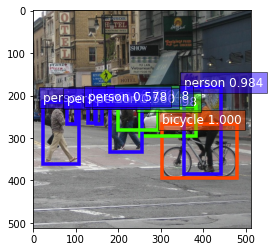

In [ ]:
class_IDs, scores, bounding_boxes = net(x)
ax = utils.viz.plot_bbox(img, bounding_boxes[0], scores[0],
                         class_IDs[0], class_names=net.classes)
plt.show()

In [ ]:
bounding_boxes.shape

(1, 100, 4)

In [ ]:
scores.shape

(1, 100, 1)

In [ ]:
pkl_path_train=os.path.join(path,"train_data.pickle")
pkl_path_val=os.path.join(path,"val_data.pickle")

if not os.path.exists(pkl_path_train):
    train_dataset = VOCDetection(root=path,splits=[(2007, 'trainval'), (2012, 'trainval')])
    print('Training images:', len(train_dataset))
    pkl_path_train=os.path.join(path,"train_data.pickle")
    with open(pkl_path_train, 'wb') as handle:
        pickle.dump(train_dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    print("Train DataSet pickle file is already available")
    with open('/content/drive/MyDrive/train_data.pickle', 'rb') as handle:
      train_data = pickle.load(handle)
    print("Total images in training set =",len(train_data))


if not os.path.exists(pkl_path_val):
    val_dataset = VOCDetection(root=path,splits=[(2007, 'test')])
    print('Validation images:', len(val_dataset))
    pkl_path_val=os.path.join(path,"val_data.pickle")
    with open(pkl_path_val, 'wb') as handle:
        pickle.dump(val_dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    print("Validation DataSet pickle file is already ")
    with open('/content/drive/MyDrive/val_data.pickle', 'rb') as handle:
      val_data = pickle.load(handle)
    print("Total images in validation set =",len(val_data))



Train DataSet pickle file is already available
Total images in training set = 16551
Validation DataSet pickle file is already 
Total images in validation set = 4952


In [ ]:
CLASSES = ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car',
               'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
               'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')

In [ ]:
def make_index_pickle(InvIndex_path,ImageBB_path,train_dataset):
    InvIndex={}
    ImageBB=[]
    for i in range(len(train_dataset)):
        if i%400==0:
            print(i)
        train_image, train_label = train_dataset[i]
        bboxes = train_label[:, :4]
        cids = train_label[:, 4:5]
        ImageBB.append(bboxes)
        for idx,classID in enumerate(cids):
            if int(classID.item()) in InvIndex:
                if i not in InvIndex[int(classID.item())]:
                    InvIndex[int(classID.item())].append([i,bboxes[idx]])
                else:
                    InvIndex[int(classID.item())]=[[i,bboxes[idx]]]
    with open(InvIndex_path, 'wb') as handle:
        pickle.dump(InvIndex, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(ImageBB_path, 'wb') as handle:
        pickle.dump(ImageBB, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return InvIndex,ImageBB


In [ ]:
InvIndex_path=os.path.join(path,"CBIR_InvIndex.pickle")
ImageBB_path=os.path.join(path,"CBIR_ImageBB.pickle")

if not (os.path.exists(InvIndex_path) or os.path.exists(ImageBB_path)):
    InvIndex,ImageBB= make_index_pickle(InvIndex_path,ImageBB_path,train_dataset)
else:
    print("Inverted Index and Bounding Box pickle files are already available")
    with open('/content/drive/MyDrive/CBIR_InvIndex.pickle', 'rb') as handle:
      testing_load = pickle.load(handle)
    with open('/content/drive/MyDrive/CBIR_ImageBB.pickle', 'rb') as handle:
      t = pickle.load(handle)

Inverted Index and Bounding Box pickle files are already available


In [ ]:
def make_final_index_pickle(InvIndex_final_path,train_dataset):
    InvIndex_final_version={}
    for i in range(len(train_dataset)):
        if i%400==0:
            print(i)
        train_image, train_label = train_dataset[i]
        bboxes = train_label[:, :4]
        cids = train_label[:, 4:5]
        lis=[]
        for j in cids:
            lis.append(int(j[0]))
        # print(cids)
        # print(lis)
        InvIndex_final_version[int(i)]= return_vector(lis)
    with open(InvIndex_final_path, 'wb') as handle:
        pickle.dump(InvIndex_final_version, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return InvIndex_final_version

def return_vector(a):
  l=[]
  d={}
  for i in a:
    if(i in d.keys()):
      d[i]=d[i]+1
    else:
      d[i]=1
  for i in range(20):
    if(i in d.keys()):
      l.append(d[i])
    else:
      l.append(0)
  return l

InvIndex_final_path=os.path.join(path,"InvIndex_final_version")

if not os.path.exists(InvIndex_final_path):
    InvIndex_final_version=make_final_index_pickle(InvIndex_final_path,train_data)
else:
    print("Final Inverted Index pickle file is already avaiable")
    with open('/content/drive/MyDrive/InvIndex_final_version', 'rb') as handle:
      InvIndex_final_version = pickle.load(handle)
  


Final Inverted Index pickle file is already avaiable


## Run The Program From Here

In [ ]:
def reverse_count(l):
  d1={}
  # A dictionary of Image Id : count
  d2={}
  for i in l:
    if(i in d1.keys()):
      d1[i]=d1[i]+1
    else:
      d1[i]=1

  for k,v in d1.items():
    if(v in d2.keys()):
      d2[v].append(k)
    else:
      d2[v]=[]
      d2[v].append(k)
  return d2

for k,v in testing_load.items():
  lis_images=[]
  for i in range(len(v)):
    lis_images.append(v[i][0])
  testing_load[k]=reverse_count(lis_images)

#Taking User Input 
####  User can make a query with any image from the validation set. We can simulate taking image as input as taking an integer input representing the image index in the validation set.

In [ ]:
idx=int(input('Provide an integer between 0 and 4951\t'))
val_image, val_label = val_data[idx]
bboxes = val_label[:, :4]
cids_Q = val_label[:, 4:5]
ax = viz.plot_bbox(
    val_image.asnumpy(),
    bboxes,
    labels=cids_Q,
    class_names=train_data.classes)
plt.show()

In [ ]:
cids_Q

array([[14.],
       [12.]], dtype=float32)

#-----------------------------------------OR------------------------------------

/usr/local/lib/python3.7/dist-packages/mxnet/gluon/block.py:1784: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


Provide an integer between 0 and 4951	190


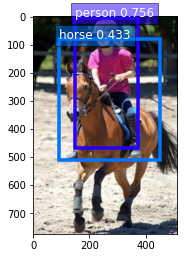

In [ ]:
#Pretrained Model
net = model_zoo.get_model('ssd_512_resnet50_v1_voc', pretrained=True)

threshold=0.5
idx=int(input('Provide an integer between 0 and 4951\t'))
val_image, _ = val_data[idx]
x, img = data.transforms.presets.ssd.transform_test(val_image,short=512)
cids_Q, scores, bboxes = net(x)
n=int(sum(scores[0]>0.5).max().asnumpy()[0])

if n<3:
  n+=1
  threshold=0

cids_Q=cids_Q[0][:n]
bboxes=bboxes[0][:n]
scores=scores[0][:n]
ax = utils.viz.plot_bbox(img, bboxes, scores,cids_Q, thresh=threshold,class_names=net.classes)
#ax = utils.viz.plot_bbox(img, bboxes[0], scores[0],cids[0], class_names=net.clas
plt.show()

In [ ]:
cids_Q=cids_Q.asnumpy()
cids_Q

array([[14.],
       [12.]], dtype=float32)

# Phase 1: Image Retrieval
#### 1. Postings List for a class is stored in the form of list of [image_index,one BB]. Thus for each BB there is an entry in the postings list of corresponding class.
#### 2. One image can be repeated in a single class' postings list because of several instances of the same object in the image
#### 3. We have to keep the count of the occurances of all images and group them based on the number of occurence. We have to count the repetition of images for a single class.
#### 4. Retrieve image only from training set and not validation set.
#### 5. These grouped images will be sent to Phase 2


#Find A Superset of Actual Images Ids Using Inverted Index

In [ ]:
lis_Query=[]
for i in cids_Q:
  lis_Query.append(int(i[0]))
cid_dict={}
for i in lis_Query:
  if(i in cid_dict.keys()):
    cid_dict[i]=cid_dict[i]+1
  else:
    cid_dict[i]=1

print(cid_dict)

{14: 1, 12: 1}


In [ ]:
imagesIDs=[]
for classID,count in cid_dict.items():
  imagesIDs=imagesIDs+testing_load[classID][count] 
print(len(imagesIDs))

3648


In [ ]:
imagesIDs_dict=reverse_count(imagesIDs)
intermediate_ans=imagesIDs_dict[max(list(imagesIDs_dict.keys()))]

# Generate Query Vector For Query Image

In [ ]:
Query_vector=[]
for i in cids_Q:
  Query_vector.append(int(i[0]))
Query_vector=return_vector(Query_vector)
print(Query_vector)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]


### 3-Types of similarity Measures

In [ ]:
b=np.array(Query_vector)
def euclidean_sim(intermediate_ans,b):
  similarity=[]
  for i in intermediate_ans:
    a=np.array(InvIndex_final_version[i])
    similarity.append((i,np.linalg.norm(a-b)))  
  similarity.sort(key=lambda x:x[1])
  return similarity
def cosine_sim(intermediate_ans,b):
  similarity=[]
  for i in intermediate_ans:
    a=np.array(InvIndex_final_version[i])
    similarity.append((i,np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))))  
  similarity.sort(key=lambda x:x[1],reverse=True)
  return similarity
def dot_sim(intermediate_ans,b):
  similarity=[]
  for i in intermediate_ans:
    a=np.array(InvIndex_final_version[i])
    similarity.append((i,np.dot(a, b)))  
  similarity.sort(key=lambda x:x[1],reverse=True)
  return similarity


### Calculate Euclidean Distance Similarity between the Images and Query

image: (364, 480, 3)
bboxes: (2, 4) class ids: (2, 1)


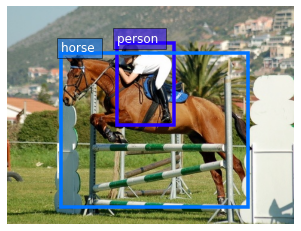

image: (480, 394, 3)
bboxes: (2, 4) class ids: (2, 1)


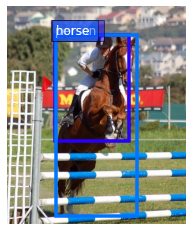

image: (480, 476, 3)
bboxes: (2, 4) class ids: (2, 1)


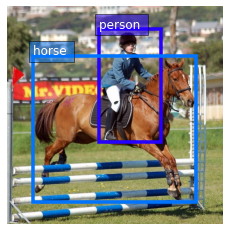

image: (360, 480, 3)
bboxes: (2, 4) class ids: (2, 1)


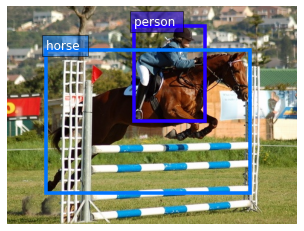

image: (332, 500, 3)
bboxes: (2, 4) class ids: (2, 1)


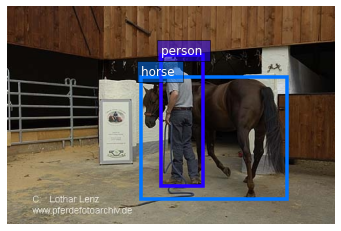

image: (480, 383, 3)
bboxes: (2, 4) class ids: (2, 1)


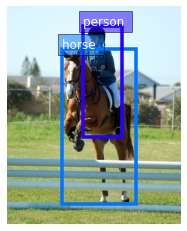

image: (322, 500, 3)
bboxes: (2, 4) class ids: (2, 1)


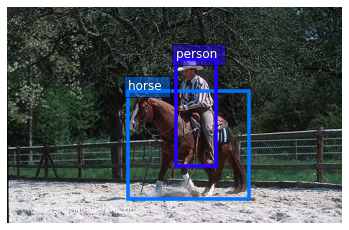

image: (441, 500, 3)
bboxes: (2, 4) class ids: (2, 1)


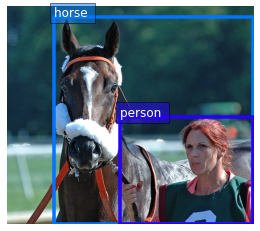

image: (375, 500, 3)
bboxes: (2, 4) class ids: (2, 1)


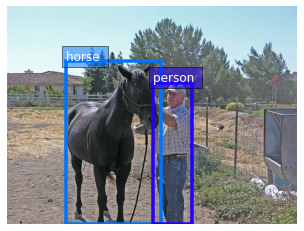

image: (480, 318, 3)
bboxes: (2, 4) class ids: (2, 1)


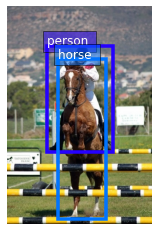

In [ ]:
l=10
similarity=euclidean_sim(intermediate_ans,b)
if(l>len(similarity)):
  l=len(similarity)
for i in range(0,l):
  train_image, train_label = train_data[similarity[i][0]]
  bboxes = train_label[:, :4]
  cids = train_label[:, 4:5]
  for q_idx,qc in enumerate(cids_Q):
    for r_idx,rc in enumerate(cids):
      qbox=bboxes[q_idx]
      ql=np.linalg.norm(np.array([qbox[0],qbox[1]])-np.array([qbox[2],qbox[3]]))
      rbox=bboxes[r_idx]
      rl=np.linalg.norm(np.array([rbox[0],rbox[1]])-np.array([rbox[2],rbox[3]]))
      #print("Score: ",np.sqrt(((1 - rl/ql) ** 2)))
  print('image:', train_image.shape)
  print('bboxes:', bboxes.shape, 'class ids:', cids.shape)
  ax = viz.plot_bbox(
      train_image.asnumpy(),
      bboxes,
      labels=cids,
      class_names=train_data.classes)
  ax.set_axis_off()
  plt.savefig('/content/drive/MyDrive/input_image_R_EUC_{}.png'.format(i), format='png')
  plt.show()

### Calculate Cosine Similarity between the Images and Query

image: (364, 480, 3)
bboxes: (2, 4) class ids: (2, 1)


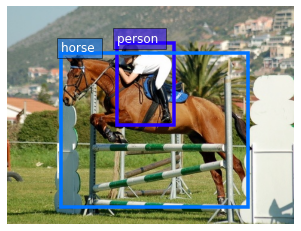

image: (480, 394, 3)
bboxes: (2, 4) class ids: (2, 1)


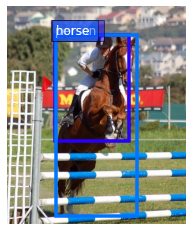

image: (480, 476, 3)
bboxes: (2, 4) class ids: (2, 1)


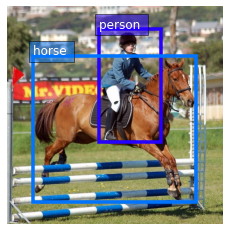

image: (360, 480, 3)
bboxes: (2, 4) class ids: (2, 1)


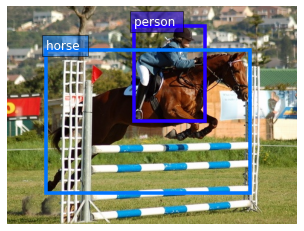

image: (332, 500, 3)
bboxes: (2, 4) class ids: (2, 1)


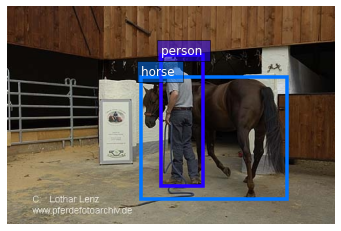

image: (480, 383, 3)
bboxes: (2, 4) class ids: (2, 1)


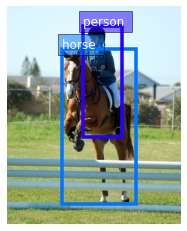

image: (322, 500, 3)
bboxes: (2, 4) class ids: (2, 1)


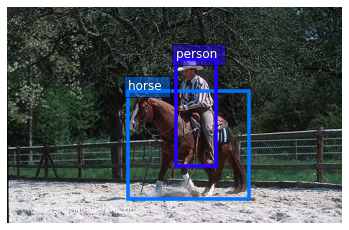

image: (441, 500, 3)
bboxes: (2, 4) class ids: (2, 1)


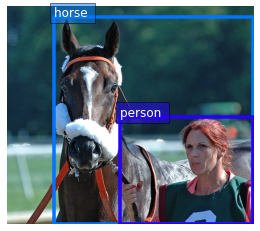

image: (375, 500, 3)
bboxes: (2, 4) class ids: (2, 1)


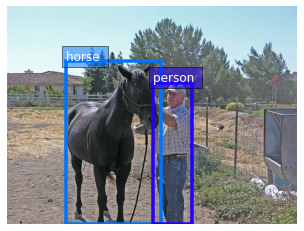

image: (480, 318, 3)
bboxes: (2, 4) class ids: (2, 1)


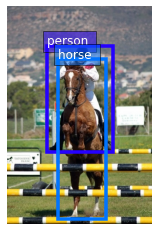

In [ ]:
l=10
similarity=cosine_sim(intermediate_ans,b)
if(l>len(similarity)):
  l=len(similarity)
for i in range(0,l):
  train_image, train_label = train_data[similarity[i][0]]
  bboxes = train_label[:, :4]
  cids = train_label[:, 4:5]
  for q_idx,qc in enumerate(cids_Q):
    for r_idx,rc in enumerate(cids):
      qbox=bboxes[q_idx]
      ql=np.linalg.norm(np.array([qbox[0],qbox[1]])-np.array([qbox[2],qbox[3]]))
      rbox=bboxes[r_idx]
      rl=np.linalg.norm(np.array([rbox[0],rbox[1]])-np.array([rbox[2],rbox[3]]))
      #print("Score: ",np.sqrt(((1 - rl/ql) ** 2)))
  print('image:', train_image.shape)
  print('bboxes:', bboxes.shape, 'class ids:', cids.shape)
  ax = viz.plot_bbox(
      train_image.asnumpy(),
      bboxes,
      labels=cids,
      class_names=train_data.classes)
  ax.set_axis_off()
  plt.savefig('/content/drive/MyDrive/input_image_R_COS_{}.png'.format(i), format='png')
  plt.show()

### Calculate dot Similarity between the Images and Query

image: (364, 480, 3)
bboxes: (2, 4) class ids: (2, 1)


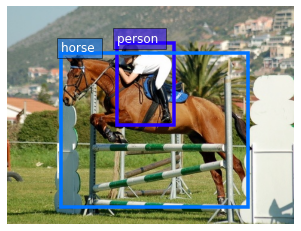

image: (480, 394, 3)
bboxes: (2, 4) class ids: (2, 1)


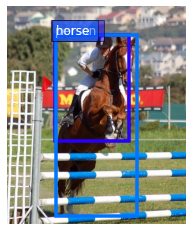

image: (480, 476, 3)
bboxes: (2, 4) class ids: (2, 1)


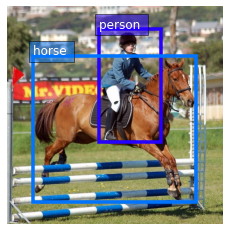

image: (360, 480, 3)
bboxes: (2, 4) class ids: (2, 1)


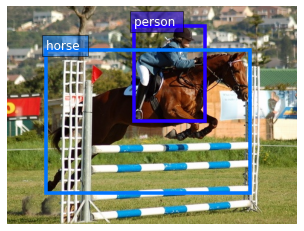

image: (332, 500, 3)
bboxes: (2, 4) class ids: (2, 1)


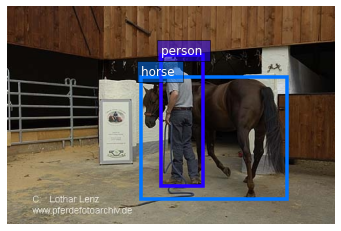

image: (480, 383, 3)
bboxes: (2, 4) class ids: (2, 1)


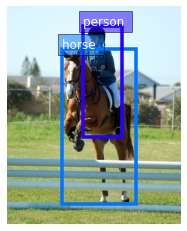

image: (322, 500, 3)
bboxes: (2, 4) class ids: (2, 1)


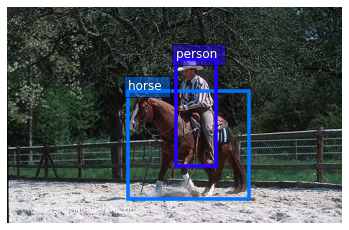

image: (441, 500, 3)
bboxes: (2, 4) class ids: (2, 1)


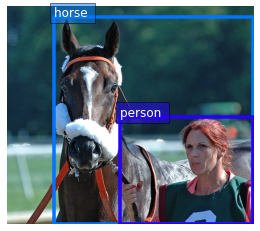

image: (375, 500, 3)
bboxes: (2, 4) class ids: (2, 1)


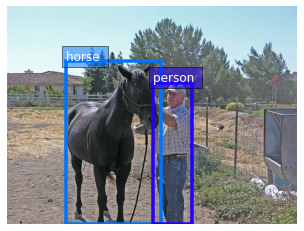

image: (375, 500, 3)
bboxes: (3, 4) class ids: (3, 1)


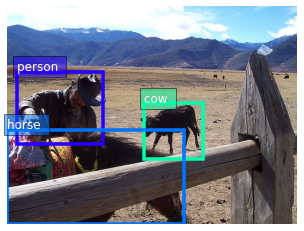

In [ ]:
l=10
similarity=dot_sim(intermediate_ans,b)
if(l>len(similarity)):
  l=len(similarity)
for i in range(0,l):
  train_image, train_label = train_data[similarity[i][0]]
  bboxes = train_label[:, :4]
  cids = train_label[:, 4:5]
  for q_idx,qc in enumerate(cids_Q):
    for r_idx,rc in enumerate(cids):
      qbox=bboxes[q_idx]
      ql=np.linalg.norm(np.array([qbox[0],qbox[1]])-np.array([qbox[2],qbox[3]]))
      rbox=bboxes[r_idx]
      rl=np.linalg.norm(np.array([rbox[0],rbox[1]])-np.array([rbox[2],rbox[3]]))
      #print("Score: ",np.sqrt(((1 - rl/ql) ** 2)))
  print('image:', train_image.shape)
  print('bboxes:', bboxes.shape, 'class ids:', cids.shape)
  ax = viz.plot_bbox(
      train_image.asnumpy(),
      bboxes,
      labels=cids,
      class_names=train_data.classes)
  ax.set_axis_off()
  plt.savefig('/content/drive/MyDrive/input_image_R_DOT_{}.png'.format(i))
  plt.show()